# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import applications
from keras.models import Sequential, Model 
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras as keras
import vis

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [165]:
y_train_1d = y_train[:, 0]
y_test_1d = y_test[:, 0]
print(y_train_1d.shape)
print(y_test_1d.shape)

(50000,)
(10000,)


In [0]:
# create two datasets one with classes from 0 to 4 and one with 5 to 9
x_train_lt5 = x_train[y_train_1d < 5]
y_train_lt5 = y_train_1d[y_train_1d < 5]
x_test_lt5 = x_test[y_test_1d < 5]
y_test_lt5 = y_test_1d[y_test_1d < 5]

x_train_gte5 = x_train[y_train_1d >= 5]
y_train_gte5 = y_train_1d[y_train_1d >= 5]
x_test_gte5 = x_test[y_test_1d >= 5]
y_test_gte5 = y_test_1d[y_test_1d >= 5]

In [167]:
print("Dataset Samples: \n")
print("X Train < 5: ", x_train_lt5[x_train_lt5 > 0])
print("X Test < 5: ", x_test_lt5[x_test_lt5 > 0])
print("Y Train < 5: ", y_train_lt5[0])
print("Y Test < 5: ", y_test_lt5[0])
print("X Train >= 5: ", x_train_gte5[x_train_gte5 > 0])
print("X Test >=5 : ", x_test_gte5[x_test_gte5 > 0])
print("Y Train >= 5: ", y_train_gte5[0])
print("Y Test >= 5: ", y_test_gte5[0])

Dataset Samples: 

X Train < 5:  [ 28  25  10 ... 163 163 161]
X Test < 5:  [158 112  49 ...  92 120  80]
Y Train < 5:  4
Y Test < 5:  3
X Train >= 5:  [59 62 63 ... 12 31 50]
X Test >=5 :  [235 235 235 ...  27  26  26]
Y Train >= 5:  6
Y Test >= 5:  8


### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [0]:
train_features_lt5 = x_train_lt5.astype('float32')/255
test_features_lt5 = x_test_lt5.astype('float32')/255
# convert class labels to binary class labels
train_labels_lt5 = keras.utils.to_categorical(y_train_lt5, 10)
test_labels_lt5 = keras.utils.to_categorical(y_test_lt5, 10)

### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

In [0]:
# input image dimensions
IMG_SIZE = 32
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3
# number of classes
num_classes = 10

conv_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = pool_size),
    Conv2D(64, kernel_size),
    keras.layers.BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = pool_size),
    Conv2D(96, kernel_size),
    keras.layers.BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = pool_size),
    Flatten(),
]

output_layers = [
    Dense(128),
    keras.layers.BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
]

In [0]:
from keras.preprocessing.image import ImageDataGenerator
#Attempting to use Data Augmentation
data = ImageDataGenerator(samplewise_center=False, # set input mean to 0 over the sample
                          samplewise_std_normalization=False,  # divide inputs by std of the sample
                          rotation_range=90,       # randomly rotate images in the range (degrees, 0 to 180)
                          width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
                          height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                          fill_mode='reflect',     # filling the area outside
                          zoom_range=0.4,          # random zoom
                          horizontal_flip=True,    # randomly flip images
                          vertical_flip=True)      # randomly flip images

In [0]:
# create complete model
model = Sequential(conv_layers + output_layers)

# Save the model 
checkpoint = ModelCheckpoint("init_model_upto_4.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

In [438]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_232 (Bat (None, 30, 30, 32)        128       
_________________________________________________________________
activation_275 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_233 (Bat (None, 13, 13, 64)        256       
_________________________________________________________________
activation_276 (Activation)  (None, 13, 13, 64)        0         
__________

In [439]:
train_features_lt5.shape[0]

25000

In [563]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit_generator(data.flow(train_features_lt5, train_labels_lt5, batch_size = 512),
          steps_per_epoch = train_features_lt5.shape[0]/350, epochs = 7,
          verbose = 1,
          callbacks = [checkpoint, early],
          validation_data= (test_features_lt5, test_labels_lt5))

Epoch 1/7
72/71 [==============================] - 38s 527ms/step - loss: 0.4075 - acc: 0.8907 - val_loss: 0.3166 - val_acc: 0.9115

Epoch 00001: val_acc did not improve from 0.93726
Epoch 2/7
72/71 [==============================] - 13s 183ms/step - loss: 0.1835 - acc: 0.9273 - val_loss: 0.2302 - val_acc: 0.9161

Epoch 00002: val_acc did not improve from 0.93726
Epoch 3/7
72/71 [==============================] - 15s 208ms/step - loss: 0.1691 - acc: 0.9300 - val_loss: 0.2169 - val_acc: 0.9166

Epoch 00003: val_acc did not improve from 0.93726
Epoch 4/7
72/71 [==============================] - 15s 203ms/step - loss: 0.1639 - acc: 0.9310 - val_loss: 0.2078 - val_acc: 0.9182

Epoch 00004: val_acc did not improve from 0.93726
Epoch 5/7
72/71 [==============================] - 15s 203ms/step - loss: 0.1608 - acc: 0.9320 - val_loss: 0.1873 - val_acc: 0.9227

Epoch 00005: val_acc did not improve from 0.93726
Epoch 6/7
72/71 [==============================] - 15s 204ms/step - loss: 0.1606 - ac

In [564]:
output_model_train = model.evaluate(train_features_lt5, train_labels_lt5)
output_model_test = model.evaluate(test_features_lt5, test_labels_lt5)

5000/5000 [==============================] - 1s 185us/step


In [567]:
print('Model Train Accuracy:', output_model_train[1] * 100, "%")
print('Model Test accuracy:', output_model_test[1] * 100, "%")

Model Train Accuracy: 92.82359925079345 %
Model Test accuracy: 92.54399892807007 %


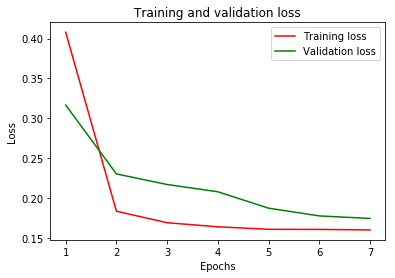

In [569]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

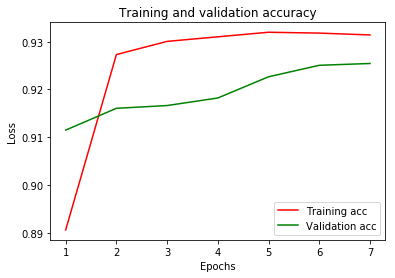

In [570]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Kindly do not consider below model. POC only.

In [0]:
#New Model, with Reference from an internet source (POC only, Please dont consider) #Please do not consider. Abandoned this approach.
model_new = Sequential()
model_new.add(Conv2D(32, kernel_size, padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_new.add(keras.layers.BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(Conv2D(32, kernel_size))
model_new.add(keras.layers.BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(MaxPooling2D(pool_size= pool_size))
model_new.add(keras.layers.BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(Conv2D(64, kernel_size))
model_new.add(keras.layers.BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(MaxPooling2D(pool_size= pool_size))
model_new.add(Conv2D(64, kernel_size))
model_new.add(keras.layers.BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(Conv2D(96, kernel_size))
model_new.add(keras.layers.BatchNormalization())
model_new.add(Activation('relu'))
model_new.add(MaxPooling2D(pool_size= pool_size))
model_new.add(Flatten())
model_new.add(Dense(512))
model_new.add(Activation('relu'))
model_new.add(Dropout(0.5))
model_new.add(Dense(256))
model_new.add(Activation('relu'))
model_new.add(Dropout(0.5))
model_new.add(Dense(num_classes, activation='softmax'))

In [217]:
model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_187 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_194 (Bat (None, 30, 30, 32)        128       
_________________________________________________________________
activation_227 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_195 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
activation_228 (Activation)  (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 32)        0         
__________

In [0]:
#model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#history_new = model_new.fit_generator(data.flow(train_features_lt5, train_labels_lt5, batch_size = 128),
#         steps_per_epoch = train_features_lt5.shape[0]/256, nb_epoch = 50,
#         verbose = 1,
#          callbacks = [checkpoint, early],
#          validation_data= (test_features_lt5, test_labels_lt5))
#Abandoned Model, Not to be considered

## Transfer Learning Starts Here

### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [0]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model.layers:
    if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
        layer.trainable = False

In [447]:
#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
    print (colored(layer.name, 'blue'))
    print (colored(layer.trainable, 'red'))

conv2d_216
False
batch_normalization_232
False
activation_275
False
max_pooling2d_93
False
conv2d_217
False
batch_normalization_233
False
activation_276
False
max_pooling2d_94
False
conv2d_218
False
batch_normalization_234
False
activation_277
False
max_pooling2d_95
False
flatten_29
False
dense_63
True
batch_normalization_235
False
activation_278
False
dropout_33
False
dense_64
True
activation_279
False


### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

In [0]:
train_features_gte5 = x_train_gte5.astype('float32')/255
test_features_gte5 = x_test_gte5.astype('float32')/255
train_labels_gte5 = keras.utils.to_categorical(y_train_gte5, 10)
test_labels_gte5 = keras.utils.to_categorical(y_test_gte5, 10)

In [449]:
print(train_labels_gte5.shape)
print(test_labels_gte5.shape)

(25000, 10)
(5000, 10)


In [450]:
#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
    print (colored(layer.name, 'blue'))
    print (colored(layer.trainable, 'red'))

conv2d_216
False
batch_normalization_232
False
activation_275
False
max_pooling2d_93
False
conv2d_217
False
batch_normalization_233
False
activation_276
False
max_pooling2d_94
False
conv2d_218
False
batch_normalization_234
False
activation_277
False
max_pooling2d_95
False
flatten_29
False
dense_63
True
batch_normalization_235
False
activation_278
False
dropout_33
False
dense_64
True
activation_279
False


In [451]:
model.layers

In [0]:
trans_model = Sequential(model.layers[:13])

In [549]:
trans_model.add(Dense(256))
trans_model.add(Activation('relu'))
trans_model.add(Dropout(0.25))
trans_model.add(Dense(10))
trans_model.add(Activation('softmax'))
trans_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_232 (Bat (None, 30, 30, 32)        128       
_________________________________________________________________
activation_275 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_233 (Bat (None, 13, 13, 64)        256       
_________________________________________________________________
activation_276 (Activation)  (None, 13, 13, 64)        0         
__________

In [0]:
trans_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [554]:
output_transfer = trans_model.fit(train_features_gte5, train_labels_gte5, batch_size = 256, epochs = 20,verbose = 2,
          validation_data= (test_features_gte5, test_labels_gte5))

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 1s - loss: 0.6795 - acc: 0.7462 - val_loss: 0.7474 - val_acc: 0.7192
Epoch 2/20
 - 1s - loss: 0.5915 - acc: 0.7807 - val_loss: 0.7830 - val_acc: 0.7052
Epoch 3/20
 - 1s - loss: 0.5499 - acc: 0.7960 - val_loss: 0.7353 - val_acc: 0.7224
Epoch 4/20
 - 1s - loss: 0.5231 - acc: 0.8086 - val_loss: 0.7295 - val_acc: 0.7282
Epoch 5/20
 - 1s - loss: 0.4970 - acc: 0.8196 - val_loss: 0.8724 - val_acc: 0.6882
Epoch 6/20
 - 1s - loss: 0.4809 - acc: 0.8234 - val_loss: 0.8794 - val_acc: 0.6986
Epoch 7/20
 - 1s - loss: 0.4630 - acc: 0.8292 - val_loss: 0.8045 - val_acc: 0.7184
Epoch 8/20
 - 1s - loss: 0.4507 - acc: 0.8371 - val_loss: 0.9357 - val_acc: 0.6884
Epoch 9/20
 - 1s - loss: 0.4367 - acc: 0.8387 - val_loss: 0.8612 - val_acc: 0.7024
Epoch 10/20
 - 1s - loss: 0.4278 - acc: 0.8438 - val_loss: 0.8780 - val_acc: 0.7124
Epoch 11/20
 - 1s - loss: 0.4125 - acc: 0.8494 - val_loss: 0.7460 - val_acc: 0.7406
Epoch 12/20
 - 1s - loss: 0.4038 - a

In [556]:
output_transfer_model_train = trans_model.evaluate(train_features_gte5, train_labels_gte5)
output_transfer_model_test = trans_model.evaluate(test_features_gte5, test_labels_gte5)

5000/5000 [==============================] - 1s 181us/step


In [566]:
print('Transfer Model Train Accuracy:', output_transfer_model_train[1] * 100, "%")
print('Transfer Model Test accuracy:', output_transfer_model_test[1] * 100, "%")

Transfer Model Train Accuracy: 74.64 %
Transfer Model Test accuracy: 70.36 %


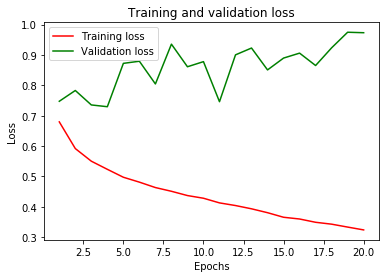

In [576]:
import matplotlib.pyplot as plt

loss = output_transfer.history['loss']
val_loss = output_transfer.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

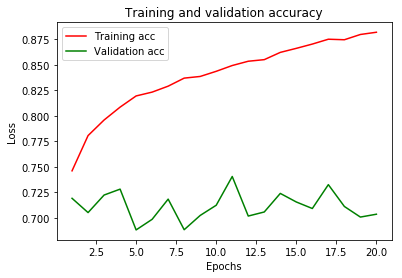

In [577]:
acc = output_transfer.history['acc']
val_acc = output_transfer.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Text classification using TF-IDF

### 6. Load the dataset from sklearn.datasets

In [0]:
from sklearn.datasets import fetch_20newsgroups

In [0]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [509]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

### 8. Test data

In [0]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [511]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2])

In [512]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [513]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

In [522]:
print(twenty_train.filenames)

['/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38440'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38479'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/soc.religion.christian/20737'
 ...
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58112'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58578'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58895']


### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [532]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(twenty_train.data)
vectors.shape

(2257, 35788)

In [0]:
from sklearn import metrics
vectors_test = vectorizer.transform(twenty_test.data)

In [539]:
vectors_test.shape

(1502, 35788)

### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

In [536]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(vectors, twenty_train.target)
pred = clf.predict(vectors_test)
metrics.f1_score(twenty_test.target, pred, average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8836373105379085

In [543]:
print("Train Accuracy: \n")
print(metrics.accuracy_score(twenty_train.target, clf.predict(vectors)))
print("\n Test Accuracy: \n")
print(metrics.accuracy_score(twenty_test.target, pred))

Train Accuracy: 

0.9827204253433761

 Test Accuracy: 

0.8868175765645806
